# Twitter Sentiment Analysis

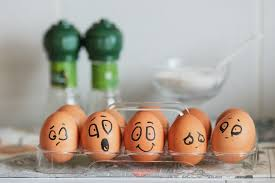

# **Overview:**

Just like you can decompose a protein into counts of amino acids, you can decompose a text document into counts of words. Here we'll attempt to create a neural network model able to classify different tweets pulled from the social media platform Twitter into one of two sentiment classes: Positive or Negative.

This work draws heavily on two overaraching conceptual frameworks within artificial intelligence and machine learning:
* **Natural Language Processing:** Natural language processing (NLP) is a subfield of computer science and artificial intelligence (AI) that involves teaching computers to understand and generate natural human language, such as text or speech. NLP has a wide range of applications, including language translation, speech recognition, and text analysis.
* **Sentiment Analysis:** Sentiment analysis is a type of NLP that involves using algorithms to automatically identify the emotional tone or sentiment in a piece of text. It is used to determine whether a piece of text is positive, negative, or neutral in tone. Sentiment analysis has a variety of applications, such as analyzing customer feedback, monitoring social media for brand reputation, and identifying trends in public opinion.

In natural language processing, we often decompose text documents into counts of their constituent words. This allows us to quantify text messages, social media posts, emails, blog posts, news articles, webpages, poems, essays, papers, speeches, and any other piece of human language, by measuring the frequency counts of the words present. Each word then becomes a variable or feature that we measure, and each sentence we analyze becomes a row in our matrix consisting of a vector of these word frequency counts.
 
However, in language, just as in protein biology, the *order* of words within a sentence is incredibly important, just as the order of amino acids fundamentally determines the biological *meaning* of a protein. 

To capture the ordered relationships between words in a sentence, we can count which words occur directly before or after other words as features themselves. We can then count pairs of words as unique features, allowing us to capture the statistically ordered relationships between words.

In understanding the statistically ordered nature of language, it should be noted that human language is inherently complex and nonlinear - just as amino acids in a protein feedback and influence one another, words in a sentence feedback on one another and influence the meaning of a sentence as an emergent property.

With this in mind, neural networks, and other deep learning models, are particularly suited to handle complex, nonlinear data such as natural language. This is because they are capable of capturing the relationships between words in a way that is not always possible with more traditional machine learning methods.

The sections in this Notebook are as follows:
1. Overview
2. Exploratory Data Analysis
3. Preprocessing
4. Modeling
    * Tokenization
    * Padding
    * Word Embedding
    * Neural Architecture
    * Evaluation
    * Saving
5. Conclusions
The dataset used here is the Sentiment140 dataset with 1.6 million tweets. See citation below for a discussion of the methodologies used in gathering this dataset.
> Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12. [(link)](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)

# Exploratory Data Analysis

In [1]:
#Load our dataset into a DataFrame
import numpy as np
import pandas as pd

DATASET_ENCODING = 'ISO-8859-1'
DATASET_COLUMNS = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

twitter_data = pd.read_csv('../Data/training.1600000.processed.noemoticon.csv', 
                             encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

twitter_data.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
#Because this dataset is quite large, it's not a bad idea to check our tail as well
twitter_data.tail()

,sentiment,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [3]:
#As well as our dataset's shape
twitter_data.shape

(1600000, 6)

In [4]:
#And check for any null values
twitter_data.isnull().sum()

sentiment    0
id           0
date         0
flag         0
user         0
text         0
dtype: int64

It's immediately clear that our target columns for analysis and modeling are the sentiment and text columns, so we'll go ahead and extract those while dropping the rest of the dataset. 

In [5]:
twitter_data = twitter_data[['sentiment', 'text']]
twitter_data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
twitter_data.groupby('sentiment').sentiment.count()

sentiment
0    800000
4    800000
Name: sentiment, dtype: int64

The researchers decided to encode the sentiment value of each tweet as negative = 0, neutral = 2, and positive = 4. 

We can see that there are no neutral tweets included in this dataset, so we'll replace these values with negative = 0 and positive = 1 for succinctness.

In [7]:
twitter_data['sentiment'] = twitter_data['sentiment'].replace(4,1)
twitter_data.groupby('sentiment').sentiment.count()

sentiment
0    800000
1    800000
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Sentiment Distribution'}, ylabel='sentiment'>

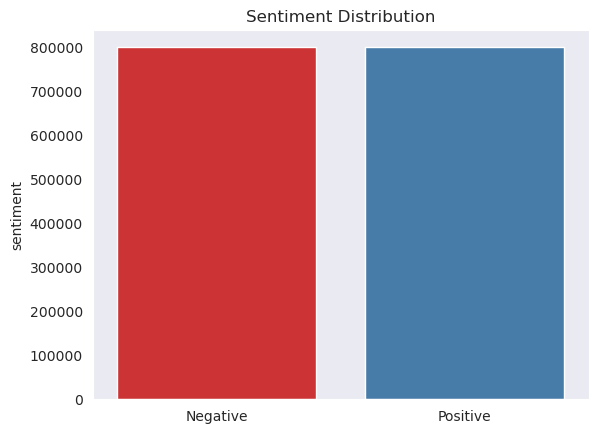

In [8]:
#We'll go ahead and visualize our sentiment class's distribution
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('dark')

counts = twitter_data.groupby('sentiment').sentiment.count()
classes = ['Negative', 'Positive']
plt.figure()
plt.title("Sentiment Distribution")
sns.barplot(x=classes, y=counts, palette='Set1')

# Preprocessing

Preprocessing text data is an integral step in Natural Language Processing (NLP), and here we define a function that will process the text of each tweet in our dataset and remove noise from our data. This is also important in bringing each tweet closer to a form that our neural network can take as input. 

The steps we'll take in preprocessing each tweet are:
1. **Lower Casing**: Convert all text to lowercase
2. **Removing URLS**: Links starting with "http", "https", or "www" are replaced by "URL"
3. **Removing Usernames**: Replace usernames with "USER"
4. **Replacing Emojis**: Replace emojis with their corresponding text using a predefined mapping of emojis and their meanings (e.g. ":)" to "EMOJIsmile")
5. **Removing Non-Alphabets**: All characters except digits and letters are replaced with a space
6. **Removing Consecutive Letters**: Reduce repeated letters to a maximum of 2 (e.g. "Heyyy" to "Heyy")
7. **Removing Short Words**: Remove words with a length of 1 or 2
8. **Removing Stopwords**: Remove stopwords that don't contribute much information to the meaning of a text to reduce the number of tokens in the text (e.g. "the", "and", "a", "an", "in", "of", "to")
9. **Lemmatizing**: Lemmatization reduces inflected words to their base or dictionary form (e.g. "running" to "run", "dogs" to "dog", "happier" to "happy")

In [9]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')

from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

This dataset was encoded in ISO-8859-1 or Latin-1, which is an 8-bit character encoding that was developed by the International Organization for Standardization (ISO). It defines a set of 256 characters that can be used in various Western European languages, including English, French, German, Spanish, and Portuguese. 

Unicode is a universal character encoding standard that can represent almost all of the characters used in human writing systems, including characters used in languages that are not based on the Latin alphabet. Unicode assigns a unique code point to each character, and it currently includes more than 143,000 characters from various scripts and languages. Most modern software uses UTF-8, and the emojis that people use in their everyday lives (across applications and communications contexts) are encoded natively within Unicode. 

Having emojis encoded as Unicode characters is a very powerful feature of modern communicaton when it comes to building machine learning models for sentiment analysis or other text classification applications. If our dataset was encoded in Unicode, we could use a map: 

emojis = {"😀": "Grinning Face", "😃": "Grinning Face with Big Eyes", "😄": "Grinning Face with Smiling Eyes",
    "😁": "Beaming Face with Smiling Eyes", "😆": "Grinning Squinting Face", "😅": "Grinning Face with Sweat",
    "🤣": "Rolling on the Floor Laughing", "😂": "Face with Tears of Joy", "🙂": "Slightly Smiling Face",
    "🙃": "Upside-Down Face", "😉": "Winking Face", "😊": "Smiling Face with Smiling Eyes",
    "😇": "Smiling Face with Halo", "🥰": "Smiling Face with Hearts", "😍": "Smiling Face with Heart-Eyes",
    "🤩": "Star-Struck", "😘": "Face Blowing a Kiss", "😗": "Kissing Face",
    "😚": "Kissing Face with Closed Eyes", "😋": "Face Savoring Food", "😛": "Face with Tongue",
    "😜": "Winking Face with Tongue", "🤪": "Zany Face", "😝": "Squinting Face with Tongue",
    "🤗": "Hugging Face", "🤭": "Face with Hand Over Mouth", "🤫": "Shushing Face",
    "🤔": "Thinking Face","🤨": "Face with Raised Eyebrow", "😐": "Neutral Face", ...}
    
In addition to map defined below, to cover both forms of communication style in building features for our neural network. However, because our data is encoded in Latin-1, we'll only use the text emoji -> emoji meaning map here.

In [11]:
#We'll define a mapping of emojis to their text meanings 

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":')": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [12]:
#We'll define our stopwords as well 
stop_words = stopwords.words('english')

In [13]:
def preprocess(textdata):
    #Define our Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #Regex patterns
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern = r"@[^\s]+"
    alpha_pattern = r"[^a-zA-Z0-9]"
    consec_letter_pattern = r"(.)\1\1+"
    consec_replace_pattern = r"\1\1"
    

    #1. Lowercasing
    textdata = textdata.lower()
    
    #2. Remove URLS
    textdata = re.sub(url_pattern, 'URL', textdata)
    
    #3. Remove usernames
    textdata = re.sub(user_pattern, 'USER', textdata)
    
    #4. Replacing emojis
    for emoji, meaning in emojis.items():
        textdata = textdata.replace(emoji, "EMOJI" + meaning)
        
    #5. Removing non-alphabets
    textdata = re.sub(alpha_pattern, ' ', textdata)
    
    #6. Removing consecutive letters 
    textdata = re.sub(consec_letter_pattern, consec_replace_pattern, textdata)
    
    # 7. Removing short words 
    textdata = ' '.join(word for word in textdata.split() if len(word) > 2)
    
    #8. Removing stopwords
    textdata = ' '.join(word for word in textdata.split() if word not in stop_words)
            
    #9. Lemmatize our word 
    textdata = ' '.join(lemmatizer.lemmatize(word) for word in textdata.split())
    
    return textdata


In [14]:
preprocess("Hi my name is @chris and tOdaY I had bad lasagna I'm so sadddd :( #sadlasagna")

'name USER today bad lasagna sadd EMOJIsad sadlasagna'

In [15]:
#Now we'll apply our text preprocessing to each sample in our dataframe
import time
t = time.time()
twitter_data['text'] = twitter_data['text'].apply(lambda x: preprocess(x))
print(twitter_data.tail())
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

         sentiment                                             text
1599995          1                    woke school best feeling ever
1599996          1      thewdb com cool hear old walt interview URL
1599997          1                   ready mojo makeover ask detail
1599998          1  happy 38th birthday boo time tupac amaru shakur
1599999          1              happy charitytuesday USER USER USER
Text Preprocessing complete.
Time Taken: 144 seconds


Let's visualize our preprocessed text at this point.

(800000,)


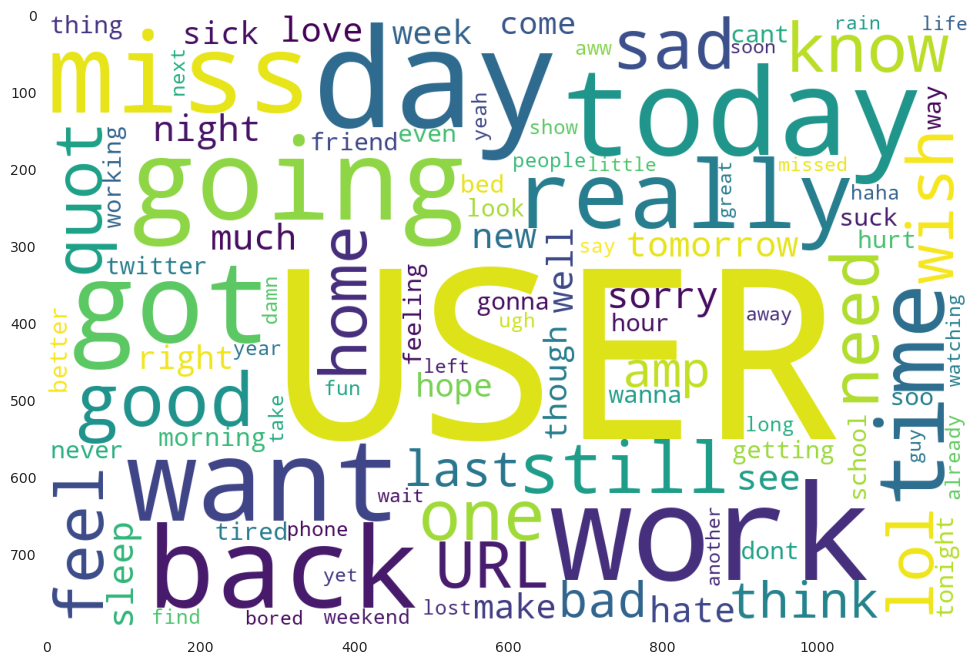

In [16]:
neg_sentiment = twitter_data['text'].loc[twitter_data['sentiment'] == 0]
print(neg_sentiment.shape)

plt.figure(figsize=(12,8))
wc = WordCloud(width=1200, height=800, max_words=100, collocations=False, 
               background_color='white').generate(' '.join(list(neg_sentiment)))
plt.imshow(wc)

(800000,)


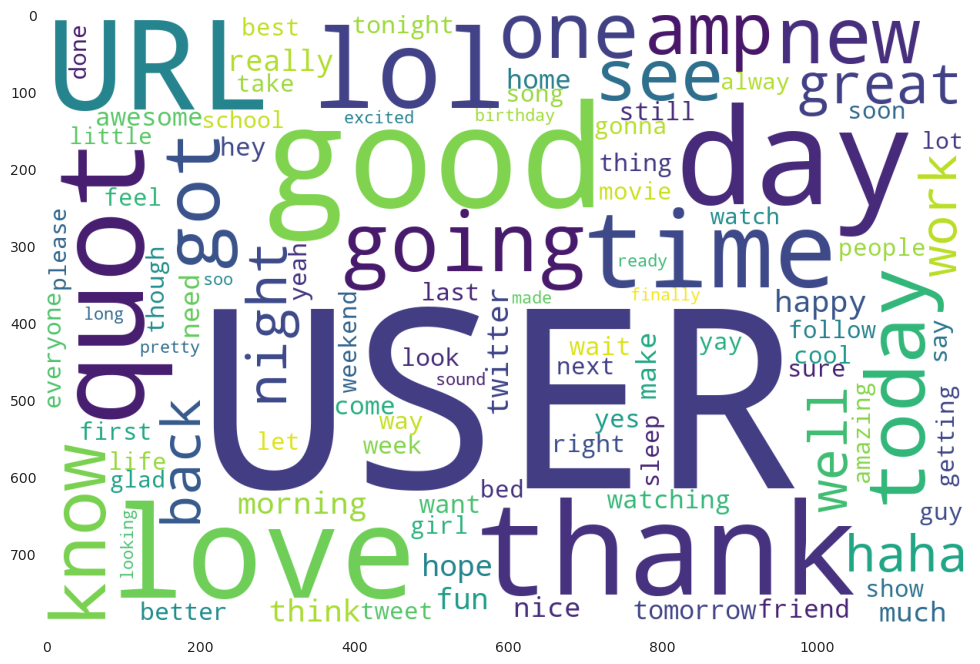

In [17]:
pos_sentiment = twitter_data['text'].loc[twitter_data['sentiment'] == 1]
print(pos_sentiment.shape)

plt.figure(figsize=(12,8))
wc = WordCloud(width=1200, height=800, max_words=100, collocations=False, 
               background_color='white').generate(' '.join(list(pos_sentiment)))
plt.imshow(wc)

We can see that despite some obvious differences in word usage between our positive and negative tweets, there is significant overlap between words in these classes - this is something to note as we move forward into our modeling.

In [18]:
from sklearn.model_selection import train_test_split

#Extract our features
X = twitter_data['text']

#Extract our target variable for classification
y = twitter_data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                   random_state=0)

# Modeling

At this stage we're ready to start building our sentiment analysis neural network model. 

Here we're going to use a **LSTM neural network model.** LSTM stands for Long Short-Term Memory, which is a type of recurrent neural network (RNN) architecture designed to handle the vanishing gradient problem that can occur in traditional RNNs. 

LSTMs use a more complex cell structure with three gates (input, forget, and output) that allow them to selectively store and retrieve information from previous time steps, which can help mitigate the vanishing gradient problem and improve performance.

In the context of sentiment analysis, LSTMs are often used to model the sequential nature of text data. LSTMs are particularly suited for capturing long-term dependencies in the input sequence, which is often important for understanding the meaning of a sentence or document. In our case, the sentiment of a sentence may depend on the presence of certain words or phrases earlier in the sentence, which may be several words or even several sentences away. By using an LSTM, the model can learn to remember these earlier features and use them to make a more accurate prediction.

In [19]:
#Settings
EMBEDDING_DIM = 50
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 8

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

print('Tensorflow Version',tf.__version__)
      

Tensorflow Version 2.11.0


# Tokenization

**Tokenization** is the process of splitting our text documents into individual word features, or **tokens**. Our tokenizer performs the following steps:

1. **Tokenization:** This step involves splitting the text into individual words.
2. **Vocabulary creation:** The tokenizer then creates a vocabulary of all the unique words in the corpus, where each word is assigned a unique integer index based on its frequency in the text. 
3. **Integer encoding:** Finally, the tokenizer replaces each word in the text with its corresponding integer index from the vocabulary. This step converts the text into a sequence of integers.

In [21]:
#We'll define our Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

print('Number of word features: ', vocab_size)

Number of word features:  217766


In [22]:
#Let's look at some of our word tokens
words = []
for word, index in word_index.items():
    words.append(word)
    if index == 20:
        break
print(words)

['user', 'day', 'good', 'get', 'like', 'url', 'quot', 'work', 'today', 'love', 'time', 'going', 'got', 'lol', 'one', 'back', 'know', 'really', 'amp', 'want']


# Padding

**Padding** is an important part of preparing our data for injection into our neural network model. When you "pad" a sequence of numbers, you are adding zeros to the beginning or end of the sequence to make it a fixed length. Padding ensures that all the input sequences have the same length, which is required for the LSTM neural network model used here. 

In [23]:
from tensorflow.keras.preprocessing import sequence
#Pad our data
MAX_LEN = 30
X_train = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen=MAX_LEN)
X_test = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen=MAX_LEN)

In [24]:
print(X_train.shape)
print(X_test.shape)

(1280000, 30)
(320000, 30)


# Word Embedding

**Global Vectors for Word Representation (GLoVe)** is an unsupervised learning algorithm developed at the University of Stanford. In this approach to building semantic vector space models of language, our **corpus** of **documents** is decomposed into a **term-term matrix** - meaning that the both the rows and columns in this matrix correspond to words within our corpus, and each entry corresponds to the number of times a given word occured in the context of another word. The statistical relationships between word occurences are the primary source of information for the GLoVe model. 

Human language is incredibly complex, and this complexity allows us to capture nuanced, rich meanings about our world. When we measure the similarity of two vectors within a simple mathematical space, say the words 'man' and 'woman' within a 2-dimensional geometric space, we've quantified these words using only two variables that we hope meaningfully represent our words. We can use nearest neighbor evaluations to compute a single scalar value that measures the "similarity" or distance between these words within this geometric space - our aspiration is that this metric captures their relatedness in this space. 

This simplicity poses a problem for us as we try to represent language quantitatively, because two words in a human language always display more intricate relationships than can be captured by a single or even a few numbers.

Instead of representing the relationship between words with a single number, GLoVe lets us use multiple dimensions, or variables, within a vector to represent the relationships between a given pair of words. This adds a tremendous amount of nuance to how we can encode and represent words mathematically within a multidimensional space. **This is like saying that instead of there being one difference between a 'man' and a 'woman', there are 50 differences, or 100 differences, or 300 differences.** Using a larger set of discriminative numbers like this is by no means perfect, but it adds a tremendous amount of power to our modeling, as well as allows us to take advantage of other interesting properties of words within our n-dimensional space.

A GLoVe embedding layer that has been trained a corpus of documents then is an incredibly meaning rich numerical environment that encodes the relationships between words in a given language. This is a valuable tool in sentiment analysis.

See the citation below for an in depth discussion about GLoVe and how this model was constructed and trained.

> Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation [(link)](https://nlp.stanford.edu/projects/glove/)

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-03-20 01:21:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-20 01:21:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-20 01:21:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [26]:
def read_glove_embeddings(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

    return word_to_vec_map

In [27]:
word_to_vec_map = read_glove_embeddings('glove.6B.50d.txt')
print('Number of 50 dimensional word vectors for embedding: ', len(word_to_vec_map))

Number of 50 dimensional word vectors for embedding:  400000


In [28]:
word_to_vec_map['hi']

array([-0.54313  ,  0.34427  ,  0.27125  ,  1.0487   , -1.1642   ,
       -1.2722   ,  0.35781  , -0.56527  , -0.29879  ,  0.85179  ,
        0.52222  , -0.0019718, -0.46435  ,  0.033631 ,  0.048367 ,
        0.78762  ,  0.075995 ,  0.51577  ,  0.34778  ,  0.53802  ,
        0.28299  , -0.1313   , -0.073753 ,  0.42614  ,  0.030954 ,
       -0.55033  , -0.99789  , -0.28947  ,  0.30517  , -1.1194   ,
        1.2957   ,  0.91165  ,  0.32222  ,  0.93405  , -0.34152  ,
       -0.62713  , -0.092165 ,  0.50901  ,  0.29204  , -0.20122  ,
        0.19614  , -0.45882  ,  1.1099   , -0.68737  ,  1.5724   ,
       -0.10446  ,  0.23594  , -0.56594  ,  0.43676  ,  0.98093  ])

In [29]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

In [30]:
cosine_similarity(word_to_vec_map['blueberry'], word_to_vec_map['cherry'])

0.6011007080278141

Now we'll build our pretrained embedding layer using our GLoVe word embeddings.

In [31]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec
        
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN, 
                            weights=[embedding_matrix], trainable=False)

# Neural Architecture

The design of this neural network evolved out of several rounds of intensive testing as well as research. Overall, I decided on a bidirectional LSTM neural network with two LSTM layers, two dropout layers, and two dense layers. As input it takes a sequence of integers (representing words) with a maximum length of MAX_LEN and produces a binary sentiment classification output. The model is designed to process sequential data, such as text, and learn the underlying patterns in the data to make accurate predictions.

The architecture for this neural network consists of 10 layers and is as follows:

1. **Input**: The input layer defines the shape of the input data. In this case, the input data is a sequence of integers with a maximum length of MAX_LEN.
2. **Embedding**: The embedding layer is applied to the input data. This layer learns an embedding for each word in the input sequence, which is a vector representation of the word that captures its semantic meaning. Here I used a pre-trained GLoVe embedding utilizing 50 dimensional word vectors first, and the 300 dimensional GloVe embedding for the final model, which significantly improved validation accuracy.
3. **Bidirectional LSTM**: The first Bidirectional LSTM layer processes the input sequence in both forward and backward directions. This layer has 64 units and returns a sequence of outputs for each input element.
4. **Dropout**: The Dropout layer randomly drops out some of the units in the LSTM layer, which can help prevent overfitting.
5. **Bidirectional LSTM**: The second Bidirectional LSTM layer processes the sequence in both directions again, but this time it does not return a sequence of outputs. Instead, it has 64 units and returns a single output for the entire sequence.
6. **Dense**: The Dense layer has 128 units and applies a linear transformation to the output of the second LSTM layer. In the final model, I increased this layer's units to 254. 
7. **Activation**: The Activation layer applies the ReLU activation function to the output of the Dense layer.
8. **Dropout**: Another Dropout layer is applied to prevent overfitting.
9. **Dense**: The final Dense layer has a single unit and produces a binary classification output.
10. **Activation**: The final Activation layer applies the sigmoid function to the output of the last Dense layer to produce a probability between 0 and 1 for the positive class.

We'll first run a training session with the model using minimized parameters to see how it performs. Then, we'll construct a final model using slightly more computationally expensive parameters that improve our model's validation accuracy. 

In [32]:
#Define our model
inputs = Input(name='inputs', shape=[MAX_LEN])
layer = embedding_layer(inputs)
layer = Bidirectional(LSTM(64, return_sequences=True))(layer)
layer = Dropout(0.5)(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(128)(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
outputs = Activation('sigmoid')(layer)
model = Model(inputs=inputs, outputs=outputs)

redu_lr = ReduceLROnPlateau(factor=0.2, min_lr = 0.0001, 
                              monitor = 'val_loss', verbose = 1)

During testing I tried both the **Adam** and the **Nadam optimizers**. I found that Nadam did iron out some of the nonlinearity in validation accuracy and validation loss during later stage epochs, indicating that it was mitigating overfitting well. However, it appeared to be slightly more computationally expensive, while at the same time requiring more time to reach minimally worse validation accuracies. So for these reasons I decided on Adam as the optimizer for this model. 

In [33]:
#Compile our model
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=LR),
              metrics=['accuracy'])

Now we begin our training of the LSTM model.

In [34]:
if tf.test.is_gpu_available():
    print('Training on GPU...')
else:
    print('Training on CPU...')

Training on GPU...


In [35]:
#Train our model
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, 
                  validation_data=(X_test, y_test), callbacks=[redu_lr])

Epoch 1/8
10000/10000 [==============================] - 151s 14ms/step - loss: 0.5144 - accuracy: 0.7440 - val_loss: 0.4889 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 2/8
10000/10000 [==============================] - 138s 14ms/step - loss: 0.4808 - accuracy: 0.7675 - val_loss: 0.4731 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 3/8
10000/10000 [==============================] - 147s 15ms/step - loss: 0.4679 - accuracy: 0.7760 - val_loss: 0.4621 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/8
10000/10000 [==============================] - 138s 14ms/step - loss: 0.4603 - accuracy: 0.7812 - val_loss: 0.4577 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 5/8
10000/10000 [==============================] - 139s 14ms/step - loss: 0.4546 - accuracy: 0.7845 - val_loss: 0.4560 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 6/8
10000/10000 [==============================] - 149s 15ms/step - loss: 0.4503 - accuracy: 0.7872 - val_loss: 0.4550 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 7/8
10000/10000 [===========

We now have a trained LSTM neural network model! We'll evaluate our model below.

In [36]:
def plot_acc_loss(history):
    history_dict = history.history
    history_df = pd.DataFrame(history_dict)
    epochs = range(1, len(history_df.accuracy) +1)

    fig, axs = plt.subplots(2,1, figsize=(12, 8))

    acc = sns.lineplot(x=epochs, y=history.history['accuracy'], label='train', c='b',
                   ax=axs[0])
    val_acc = sns.lineplot(x=epochs, y=history.history['val_accuracy'],label='test',
                       c='r', ax=axs[0])

    loss = sns.lineplot(x=epochs, y=history.history['loss'], label='train',
                   ax=axs[1])
    val_loss = sns.lineplot(x=epochs, y=history.history['val_loss'], label='test',
                   ax=axs[1])

    #Titles for each subplot
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel('accuracy')
    axs[0].legend(loc='lower right')
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel('loss')

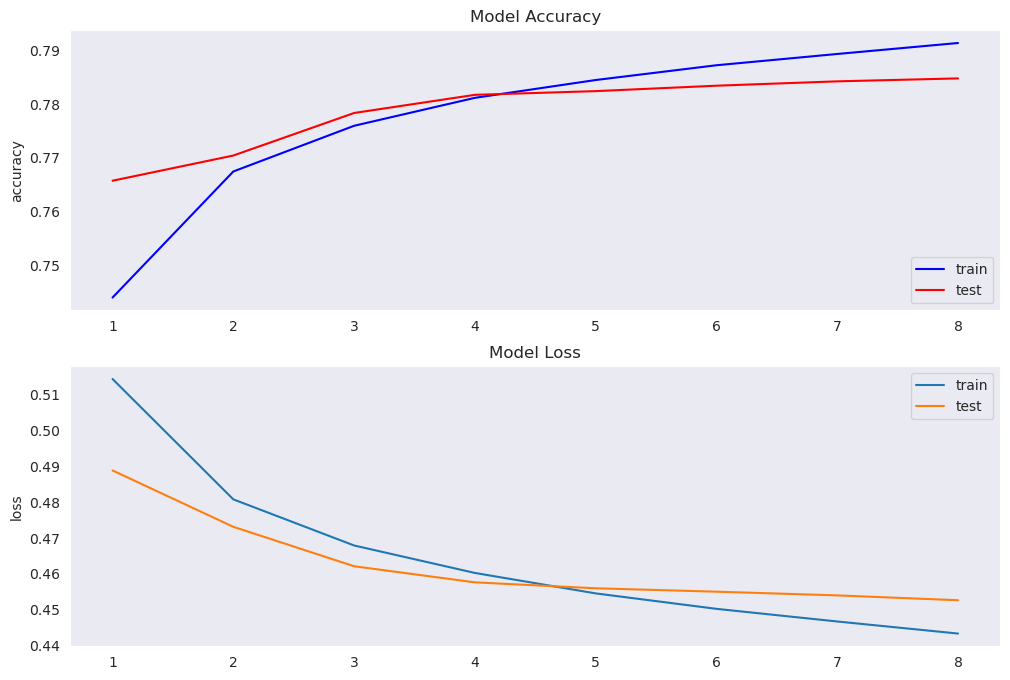

In [37]:
plot_acc_loss(history)

We'll note that we seem to plateau out at **0.7848 validation accuracy** and **0.4527 validation loss** at **epoch 8**. Further testing up to 20 epochs confirmed that this is where overfitting occurs using the current parameters with this model. 

In [38]:
def thresh_sentiment(sent_value):
    if sent_value > 0.5:
        return 1
    else:
        return 0

y_pred = model.predict(X_test)
y_pred = [thresh_sentiment(y) for y in y_pred]

10000/10000 [==============================] - 47s 5ms/step


In [39]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

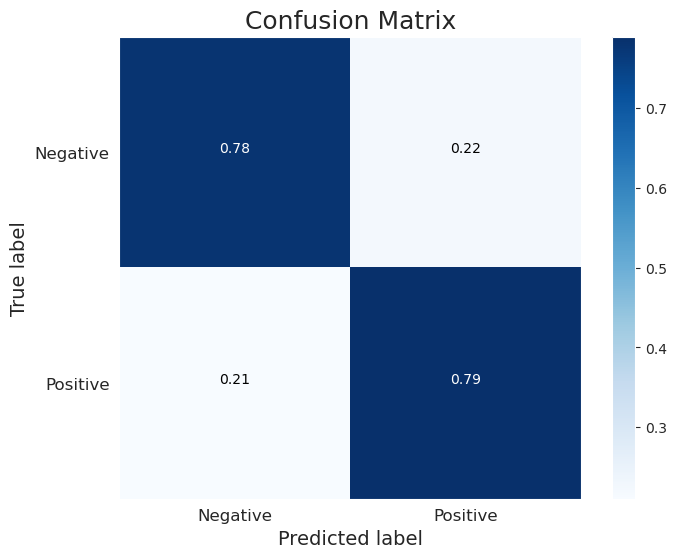

In [40]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion Matrix")
plt.show()

In [41]:
print(classification_report(list(y_test), y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78    159815
    Positive       0.78      0.79      0.79    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



From our **confusion matrix** and **classification report** we can see that our LSTM neural network is better at correctly classifying positive tweets than it is at classifying negative tweets. A recall score of 0.78 for negative tweets means that out of all the actual negative tweets in the dataset, the model correctly identified 78% of them as negative. Similarly, a recall score of 0.79 for positive tweets means that out of all the actual positive tweets in the dataset, the model correctly identified 79% of them as positive. There are many possible reasons for this, but it does point towards some further work that could be done in terms of preprocessing our text data, because this dataset was perfectly balanced in that we had no skewness in distribution for our sentiment classes.

Having run this exploratory training session, we'll define our final LSTM neural network model and train it. 

In [42]:
EMBEDDING_DIM = 300
EPOCHS = 4

Here we'll use the full 300 dimensional GLoVe word embedding as our pre-trained embedding layer.

In [43]:
word_to_vec_map = read_glove_embeddings('glove.6B.300d.txt')
print('Number of 300 dimensional word vectors for embedding: ', len(word_to_vec_map))

Number of 300 dimensional word vectors for embedding:  400000


In [44]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec
        
final_embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN, 
                            weights=[embedding_matrix], trainable=False)

Note that I've increased both bidirectional LSTM layers to have 128 neurons, and our first dense layer to have 254 neurons, in addition to increasing the dimensionality of our embedding layer to 300 dimensions. 

In [45]:
tf.keras.backend.clear_session()

In [46]:
#Define our final model
inputs = Input(name='inputs', shape=[MAX_LEN])
layer = final_embedding_layer(inputs)
layer = Bidirectional(LSTM(128, return_sequences=True))(layer)
layer = Dropout(0.5)(layer)
layer = Bidirectional(LSTM(128))(layer)
layer = Dense(254)(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
outputs = Activation('sigmoid')(layer)
final_model = Model(inputs=inputs, outputs=outputs)

In [47]:
#Compile our final model
final_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=LR),
              metrics=['accuracy'])

And here we go!

In [48]:
if tf.test.is_gpu_available():
    print('Training on GPU...')
else:
    print('Training on CPU...')

Training on GPU...


In [49]:
#Train our final model
final_history = final_model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, 
                  validation_data=(X_test, y_test), callbacks=[redu_lr])

Epoch 1/4
10000/10000 [==============================] - 205s 20ms/step - loss: 0.4754 - accuracy: 0.7708 - val_loss: 0.4504 - val_accuracy: 0.7878 - lr: 0.0010
Epoch 2/4
10000/10000 [==============================] - 203s 20ms/step - loss: 0.4436 - accuracy: 0.7914 - val_loss: 0.4394 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 3/4
10000/10000 [==============================] - 198s 20ms/step - loss: 0.4277 - accuracy: 0.8006 - val_loss: 0.4352 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 4/4
10000/10000 [==============================] - 204s 20ms/step - loss: 0.4145 - accuracy: 0.8079 - val_loss: 0.4382 - val_accuracy: 0.7944 - lr: 0.0010


# Evaluation

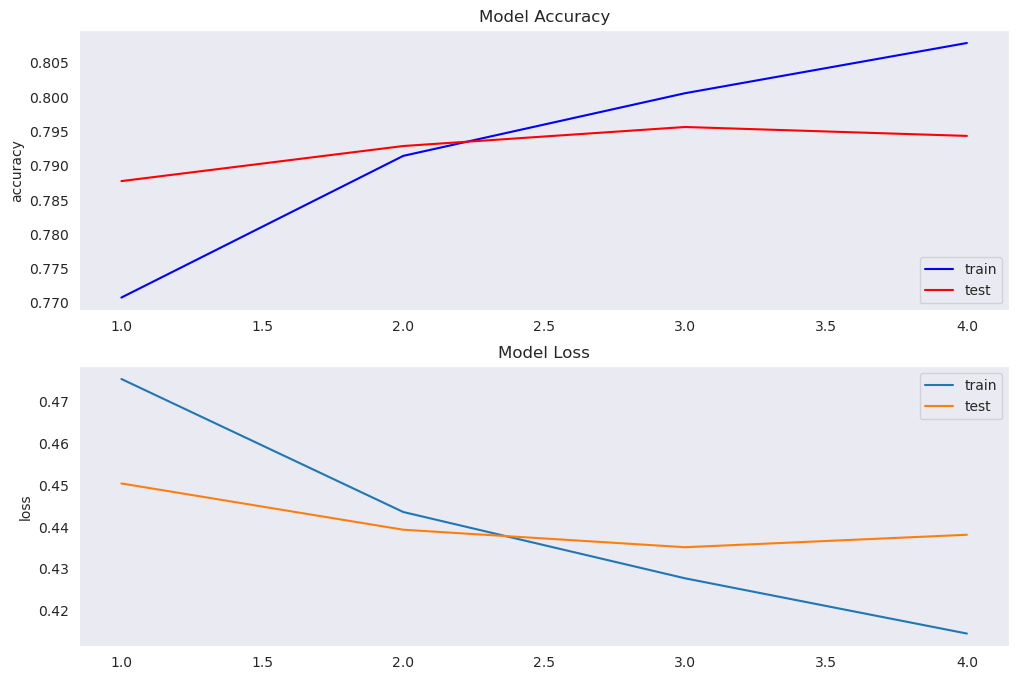

In [50]:
plot_acc_loss(final_history)

We can see that we plateau out at **0.7957 validation accuracy** and **0.4352 validation loss** at **epoch 3**. Further testing up to 10 epochs confirmed that this is where the model begins overfitting. 

In [51]:
y_pred = final_model.predict(X_test)
y_pred = [thresh_sentiment(y) for y in y_pred]

10000/10000 [==============================] - 52s 5ms/step


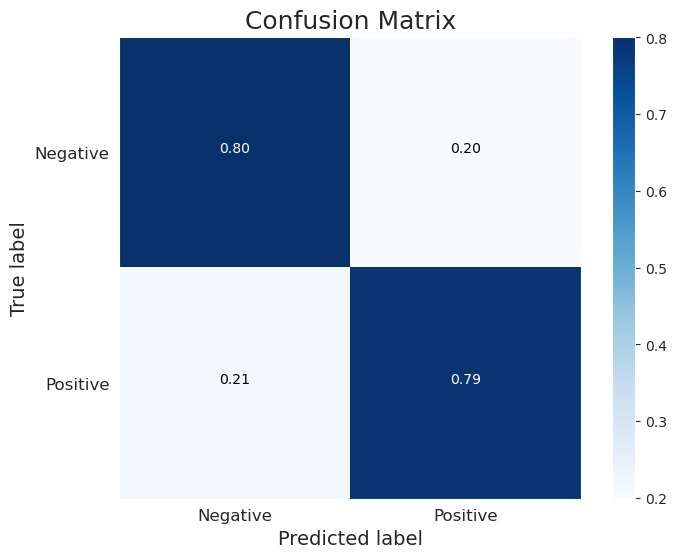

In [52]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion Matrix")
plt.show()

In [53]:
print(classification_report(list(y_test), y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.80      0.80    159815
    Positive       0.80      0.79      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



We can see that while this model still has the same success correctly classifying positive tweets, we were able to bring up its negative tweet recall to 0.80. This might indicate that there are underlying patterns in negative tweets that are more difficult for the simpler model to learn and capture compared to positive tweets, that we might be able to uncover during more intensive exploration and focused preprocessing of negatively classed tweets.

Let's look at how our model handles some specific examples.

In [54]:
def predict(text):
    start_at = time.time()
    # Preprocess text 
    preprocess(text)
    # Tokenize text
    x_test = sequence.pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_LEN)
    # Predict
    score = final_model.predict([x_test])[0]
    # Decode sentiment
    label = thresh_sentiment(score)
    if label == 1:
        label = 'Positive'
    else:
        label = 'Negative'

    return {"label": label, "score": float(score),
       "elapsed time": time.time()-start_at} 

In [55]:
predict("My dog just learned how to give high fives and I'm pretty sure this is the greatest moment of my life. #dogfive")

1/1 [==============================] - 2s 2s/step


{'label': 'Positive',
 'score': 0.7648866176605225,
 'elapsed time': 2.0060532093048096}

In [56]:
predict("If you want to experience disappointment, try the pizza at that new place down the street. It's like they put ketchup on a piece of cardboard. #lame")

1/1 [==============================] - 0s 25ms/step


{'label': 'Negative',
 'score': 0.025944527238607407,
 'elapsed time': 0.0665900707244873}

In [57]:
predict("Finally finished my big project at work... and now have nothing to do. I'm so relieved, yet also so bored! #happyandsad #worklifebalance")

1/1 [==============================] - 0s 23ms/step


{'label': 'Negative',
 'score': 0.4243983328342438,
 'elapsed time': 0.06139349937438965}

We'll now save our final model.

In [58]:
final_model.save("lstm_final_model")

# Conclusions

Here we explored the use of an LSTM neural network for sentiment analysis on a dataset of 1.6 million tweets. Our results showed that the model achieved reasonable accuracy in classifying tweets as positive or negative, with recall scores of 0.79 and 0.80 for positive and negative tweets, respectively.

This analysis revealed some interesting patterns in the language used in positive and negative tweets, with certain words and phrases being strongly associated with either positive or negative sentiment. Additionally, we observed that the original model performed better at identifying positive tweets, suggesting that negative sentiment in tweets may be more complex and require more sophisticated preprocessing techniques.

However, there are also limitations to our approach, such as the lack of diversity in the types of tweets included and the fact that Unicode encoded emojis were not included in the dataset. In future work, it would be beneficial to explore more diverse datasets, as well as experiment with different preprocessing techniques and neural network architectures to further improve performance.

Overall, our findings demonstrate the potential of using deep learning models like LSTM for sentiment analysis in social media data, and open the door for further research and development using deep learning models to understand natural language.